# Setup

In [26]:
import sys
sys.path.insert(
    0, '/home/student.unimelb.edu.au/shorte1/Documents/TINT')

In [27]:
import sys
sys.path.insert(0, '/home/563/esh563/TINT')

In [28]:
# Core
import datetime
import os
import glob
import tempfile
import pickle
import copy

# Analysis
import numpy as np
import pandas as pd
import xarray as xr

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Debugging
import pdb, traceback
# %load_ext line_profiler

# Radar Tools
import pyart
import tint
# import tint.animate
# from tint.visualisation import animate

import CPOL_func as cf
import caine_func as caf
import analysis

# Convenience functions
%load_ext autoreload
%autoreload 1
%aimport CPOL_func
%aimport caine_func
%aimport tint.visualisation.figures
%aimport tint.visualisation.animate
%aimport tint.visualisation.horizontal_helpers
%aimport tint.visualisation.vertical_helpers
%aimport tint.tracks
%aimport tint.objects
%aimport tint.grid_utils
%aimport tint.steiner
%aimport tint.matching
%aimport tint.rain
%aimport tint.cells
%aimport tint.tracks_helpers
%aimport tint.process_ERA5
%aimport tint.process_WRF
%aimport tint.process_ACCESS

%pdb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Automatic pdb calling has been turned OFF


In [29]:
base_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/CPOL/'
save_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_tracks/'
fig_dir = '/home/student.unimelb.edu.au/shorte1/Documents/TINT_figures/'
ERA5_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/era5/'
ERA5_dir += 'pressure-levels/reanalysis/'
WRF_dir = '/media/shorte1/Ewan\'s Hard Drive/phd/data/caine_WRF_data/'

In [5]:
base_dir = '/g/data/hj10/cpol/cpol_level_1b/v2020/gridded/grid_150km_2500m/'
save_dir = '/home/563/esh563/TINT_tracks/'
fig_dir = '/home/563/esh563/TINT_figures/'
ERA5_dir = '/g/data/rt52/era5/pressure-levels/reanalysis/'

# Create Tracks

In [30]:
b_path = '/home/student.unimelb.edu.au/shorte1/Documents/'
b_path += 'CPOL_analysis/circ_b_ind_set.pkl'
with open(b_path, 'rb') as f:
    b_ind_set = pickle.load(f)

In [31]:
topog_files = open('topog_files.txt', 'r')
topog_files = topog_files.read().split('\n')[:-1]
u_files = open('u_files.txt', 'r')
u_files = u_files.read().split('\n')[:-1]
v_files = open('v_files.txt', 'r')
v_files = v_files.read().split('\n')[:-1]
maxcol_refl_files = open('maxcol_refl_files.txt', 'r')
maxcol_refl_files = maxcol_refl_files.read().split('\n')[:-1]
radar_refl_1km_files = open('radar_refl_1km_files.txt', 'r')
radar_refl_1km_files = radar_refl_1km_files.read().split('\n')[:-1]

files_list = [
    topog_files, u_files, v_files, maxcol_refl_files, radar_refl_1km_files]

dates_list = []
for files in files_list:

    dates = [f.split('/')[7] for f in files]
    dates = [
        np.datetime64('{}-{}-{}'.format(f[:4], f[4:6], f[6:8])) 
        for f in dates]
    dates_list.append(set(dates))
    
[topog_dates, u_dates, v_dates, maxcol_refl_dates, radar_refl_1km_dates] = dates_list

In [32]:
files_63 = open('files_63.txt', 'r')
files_63 = files_63.read().split('\n')[:-1]
files_77 = open('files_77.txt', 'r')
files_77 = files_77.read().split('\n')[:-1]
files_42 = open('files_42.txt', 'r')
files_42 = files_42.read().split('\n')[:-1]

files_list = [
    files_63, files_77, files_42]

dates_list = []
for files in files_list:

    dates = [f.split('/')[8].split('_')[1] for f in files]
    dates = [
        np.datetime64('{}-{}-{}'.format(f[:4], f[4:6], f[6:8])) 
        for f in dates]
    dates_list.append(set(dates))
    
[dates_63, dates_77, dates_42] = dates_list

In [33]:
start = np.datetime64('2020-10-01T00:00:00')
end = np.datetime64('2021-05-01T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))

In [8]:
start = np.datetime64('2020-12-01T00:00:00')
end = np.datetime64('2020-12-02T00:00:00')
datetimes = np.arange(start, end, np.timedelta64(10,'m'))

In [34]:
common_dates = []
membership = []

dates_int = maxcol_refl_dates.intersection(
    radar_refl_1km_dates, dates_63, dates_42, dates_77)

G3_int = u_dates.intersection(v_dates)

for dt in datetimes:
    # Remember we use the previous day's reflectivity at 1200 
    date = np.datetime64(str(dt-np.timedelta64(1,'D'))[0:10])
    current_date = np.datetime64(str(dt)[0:10])
    hour = int(str(dt)[11:13])
    hour_round = (hour // 6) * 6
    date_hour = current_date + np.timedelta64(hour_round, 'h')
#     import pdb; pdb.set_trace()
    date_cond = date in dates_int
    hour_cond = (
        (date_hour in G3_int)
        and (date_hour + np.timedelta64(6, 'h') in G3_int))
    if date_cond:
        common_dates.append(dt)
        membership.append(1)
    else:
        membership.append(0)

In [20]:
date_strings = list(np.array(common_dates).astype(str))
np.savetxt(
    'test.csv', date_strings, delimiter =", ", fmt ='% s')

In [35]:
datetimes = np.loadtxt(
    'ACCESS_radar_common_times.csv', dtype=str).astype(np.datetime64)

In [36]:
# start = np.datetime64('2021-10-01T00:00:00')
# end = np.datetime64('2022-05-01T00:00:00')
# datetimes = np.arange(start, end, np.timedelta64(10,'m'))
datetimes = np.array(common_dates)

micro_physics = 'ACCESS'

tracks_obj  = tint.Tracks(params={
    'AMBIENT': 'ACCESS', 'AMBIENT_BASE_DIR': None,
    'GS_ALT': 0,
    'LEVELS': np.array(
        [[0, 0.5], [1, 1.5]]),
    'WIND_LEVELS': np.array(
        [[500, 3500], [500, 20000]]),
    'FIELD_THRESH': ['convective', 15],
    'MIN_SIZE': [80, 800],
    'ISO_THRESH': [10, 10],
    'INPUT_TYPE': 'ACCESS_DATETIMES',
    'SAVE_DIR': save_dir,
    'REFERENCE_GRID_FORMAT': 'ODIM',
    'RESET_NEW_DAY': True,
    'REFERENCE_RADAR': 77})

grids = (
    date for date in datetimes)

tracks_obj.get_tracks(grids, b_path=b_path)

Creating a reference grid.


/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/pyart/map/gates_to_grid.py:166: DeprecationWarning: Barnes weighting function is deprecated. Please use Barnes 2 to be consistent with Pauley and Wu 1990. Default will be switched to Barnes2 on June 1st.
  warnings.warn("Barnes weighting function is deprecated."


Interpolating ACCESS-C reflectivity at 2020-10-01T00:00:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Getting ACCESS-G ambient winds at 2020-10-01T00:00:00.000000.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 0.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8.
Updating ACCESS-C pseudo pyart reflectivity grid.


/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/numba/core/consts.py:114: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return getattr(value, expr.attr)
/home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/numba/core/ir_utils.py:2097: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int

No objects found in scan 9.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21.
Updating ACCESS-C pseudo

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 120.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 121.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 122.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 123.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 124.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 125.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 126.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 127.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 128.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 129.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 130.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 131.
Updating ACCESS-C pseudo pyart reflectiv

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 249.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 250.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 251.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 252.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 253.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 254.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 255.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 256.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 257.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 258.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 259.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 260.
Updating ACCESS-C pseudo pyart reflectiv

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 368.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 369.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 370.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 371.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 372.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 373.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 374.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 375.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 376.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 377.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 378.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 379.
Updating ACCESS-C pseudo pyart reflectiv

No objects found in scan 485.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 486.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 487.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 488.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 489.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 490.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 491.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 492.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 493.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 494.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 495.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 496.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 497.
Updating A

No objects found in scan 600.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 601.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 602.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 603.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 604.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 605.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 606.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 607.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 608.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 609.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 610.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 611.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 612.
Updating A

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 708.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 709.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 710.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 711.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 713.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 715.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 718.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 719 last before new day.
Interpolating ACCESS-C reflectivity at 2

No objects found in scan 826.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 827.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 828.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 829.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 830.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 831.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 832.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 833.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 834.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 835.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 836.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 837.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 838.
Updating A

No objects found in scan 945.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 946.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 947.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 948.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 949.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 950.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 951.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 952.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 953.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 954.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 955.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 956.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 957.
Updating A

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1057.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1058.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1059.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1060.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1061.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1062.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1063.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1064.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1065.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1066.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1067.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1068.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1178.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1179.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1180.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1181.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1182.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1183.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1184.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1185.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1188.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1189.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2020-10-10T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-10-10. Resetting objects.
No objects found in scan 1296.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1297.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1298.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1299.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1300.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1301.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1302.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1303.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1304.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1305.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1306.
Updatin

No objects found in scan 1426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1427.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1428.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1429.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1430.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1431.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1432.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1433.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1434.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1435.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1436.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1437.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 143

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1567.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1568.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1569.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1570.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1571.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1572.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1573.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1574.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1575.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1576.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1577.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1578.
Updating ACCESS-C pseudo pya

No objects found in scan 1690.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1691.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1692.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1693.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1694.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1695.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1696.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1697.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1698.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1699.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1700.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1701.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 170

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1804.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1805.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1806.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1807.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1808.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1809.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1810.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1811.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1812.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1813.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1814.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1815.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1933.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1934.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1935.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1936.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1937.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1938.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1939.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1940.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1941.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1942.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1943.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 1944.
Updating ACCESS-C pseudo pya

No objects found in scan 2042.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2043.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2044.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2045.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2046.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2047.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2048.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2049.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2050.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2051.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2052.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2053.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 205

No objects found in scan 2147.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2148.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2149.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2150.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2151.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2152.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2153.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2154.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2155.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2156.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2157.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2158.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 2159 last before new da

No objects found in scan 2262.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2263.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2264.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2265.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2266.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2267.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2268.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2269.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2270.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2271.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2272.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2273.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 227

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2379.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2380.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2381.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2382.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2383.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2384.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2385.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2386.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2387.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2388.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2389.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2390.
Updating ACCESS-C pseudo pya

No objects found in scan 2479.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2480.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2481.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2482.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2483.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2484.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2485.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2486.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2487.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2488.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2489.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2490.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 249

Interpolating ACCESS-C reflectivity at 2020-10-19T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-10-19. Resetting objects.
No objects found in scan 2592.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2593.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2594.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2595.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2596.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2597.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2598.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2599.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2600.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2601.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2602.
Updatin

No objects found in scan 2718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2719.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2720.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2721.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2722.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2723.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2724.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2725.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2726.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2727.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2728.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2729.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 273

No objects found in scan 2845.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2846.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2847.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2848.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2849.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2850.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2851.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2852.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2853.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2854.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2855.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2856.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 285

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2964.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2965.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2966.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2967.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2968.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2969.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2970.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2971.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2973.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2974.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 2975.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3076.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3077.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3078.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3079.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3080.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3081.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3082.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3083.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3084.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3085.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3086.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3087.
Updating ACCESS-C pseudo pya

No objects found in scan 3201.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3202.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3203.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3204.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3205.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3206.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3207.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3208.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3209.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3210.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3211.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3212.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 321

Writing tracks for scan 3306.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3307.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3308.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3309.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3310.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 3311 last before new day.
Interpolating ACCESS-C reflectivity at 2020-10-24T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updat

No objects found in scan 3394.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3395.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3396.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3397.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3398.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3399.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3400.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3401.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3402.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3403.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3404.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3405.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 340

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3494.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3495.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3496.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3497.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3498.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3499.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3500.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3501.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3502.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3503.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3504.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3505.
Updating ACCESS-C pseudo pyart reflectiv

Getting ACCESS-G ambient winds at 2020-10-26T01:50:00.000000.
Writing tracks for scan 3602.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3603.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3604.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3605.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3606.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3607.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3608.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3609.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3610.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3611.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3612.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3613.
Updating ACCESS-C pseudo pya

No objects found in scan 3709.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3710.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3711.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3713.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3715.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3719.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 3720.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 372

Getting ACCESS-G ambient winds at 2020-10-27T12:00:00.000000.
Writing tracks for scan 3807.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3808.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3809.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3810.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3811.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3812.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3813.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3814.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3815.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3816.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3817.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3818.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3906.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3907.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3908.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3909.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3910.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3911.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3912.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3913.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3914.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-10-28T06:00:00.000000.
Getting ACCESS-G ambient winds at 2020-10-28T06:00:00.000000.
Writing tracks for scan 3915.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 3

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4008.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4009.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4010.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4011.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4012.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4013.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4014.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4015.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4016.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4017.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4018.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4019.
Updating ACCESS-C pseudo pya

No objects found in scan 4128.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4129.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4130.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4131.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4132.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4133.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4134.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4135.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4136.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4137.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4138.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4139.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 414

No objects found in scan 4244.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4245.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4246.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4247.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4248.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4249.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4250.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4251.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4252.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4253.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4254.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4255.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 425

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4346.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Time discontinuity at 2020-10-31 06:00:00.
No objects found in scan 4347.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4348.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4349.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4350.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4351.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4352.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4353.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4354.
Upd

Interpolating ACCESS-C reflectivity at 2020-11-01T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-11-01. Resetting objects.
No objects found in scan 4452.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4453.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4454.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4455.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4456.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4457.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4458.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4459.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4460.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4461.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4462.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4568.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4569.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4570.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4571.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4572.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4573.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4574.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4575.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4576.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4577.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4578.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4579.
Updating ACCESS-C pseudo pya

No objects found in scan 4673.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4674.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4675.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4676.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4677.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4678.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4679.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4680.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4681.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4682.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4683.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4684.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 468

No objects found in scan 4774.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4775.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4776.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4777.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4778.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4779.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4780.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4781.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4782.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4783.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4784.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4785.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 478

Interpolating ACCESS-C reflectivity at 2020-11-04T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-11-04. Resetting objects.
No objects found in scan 4884.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4885.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4886.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4887.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4888.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4889.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4890.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4891.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4892.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4893.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 4894.
Updatin

No objects found in scan 5011.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5012.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5013.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5014.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5015.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5016.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5017.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5018.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5019.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5020.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5021.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5022.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 502

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5147.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5148.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5149.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5150.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5151.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5152.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5153.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5154.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5155.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5156.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5157.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5158.
Updating ACCESS-C pseudo pya

No objects found in scan 5255.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5256.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5257.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5258.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5259.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5260.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5261.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5262.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5263.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5264.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5265.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5266.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 526

No objects found in scan 5381.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5382.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5383.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5384.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5385.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5386.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5387.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5388.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5389.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5390.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5391.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5392.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 539

Getting ACCESS-G ambient winds at 2020-11-08T03:30:00.000000.
Writing tracks for scan 5481.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5482.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5483.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5484.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5485.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5486.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5487.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5488.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5489.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5490.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5491.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5492.
Updating ACCESS-C pseudo pya

No objects found in scan 5587.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5588.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5589.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5590.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5591.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5592.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5593.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5594.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5595.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5596.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5597.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5598.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 559

No objects found in scan 5689.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5690.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5691.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5692.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5693.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5694.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5695.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5696.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5697.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5698.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5699.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5700.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 570

Writing tracks for scan 5788.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5789.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5790.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5791.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5792.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5793.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5794.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5795.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5796.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5797.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5798.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5799.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 5800.
Updating A

Interpolating ACCESS-C reflectivity at 2020-11-11T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-11-11. Resetting objects.
No objects found in scan 5892.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5893.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5894.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5895.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5896.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5897.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5898.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5899.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5900.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5901.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 5902.
Updatin

No objects found in scan 6008.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6009.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6010.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6011.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6012.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6013.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6014.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6015.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6016.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6017.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6018.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6019.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 602

No objects found in scan 6142.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6143.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6144.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6145.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6146.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6147.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6148.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6149.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6150.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6151.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6152.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6153.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 615

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6251.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6252.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6253.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6254.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6255.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6256.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6257.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6258.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6259.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6260.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6261.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6262.
Updating ACCESS-C pseudo pya

No objects found in scan 6355.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-11-14T05:20:00.000000.
Getting ACCESS-G ambient winds at 2020-11-14T05:20:00.000000.
Writing tracks for scan 6356.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6357.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6358.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6359.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6360.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6361.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6362.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6363.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6364.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6365.
Updating ACCESS-C pseudo pyart refle

No objects found in scan 6459.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6460.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6461.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6462.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6463.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6464.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6465.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6466.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 6467 last before new day.
Interpolating ACCESS-C reflectivity at 2020-11-15T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-11-15. Resetting objects.
No objects found in scan 6468.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6469.
Updating ACCESS-C pseudo pyart reflectivity grid.
No obje

No objects found in scan 6563.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6564.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6565.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6566.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6567.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6568.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6569.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6570.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6571.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6572.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6573.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6574.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 657

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6682.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6683.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6684.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6685.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6686.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6687.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6688.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6689.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6690.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6691.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6692.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6693.
Updating ACCESS-C pseudo pya

No objects found in scan 6787.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6788.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6789.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6790.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6791.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-11-17T06:00:00.000000.
Getting ACCESS-G ambient winds at 2020-11-17T06:00:00.000000.
Writing tracks for scan 6792.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6793.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6794.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6795.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6796.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 6797.
Updating ACCESS-C pseudo pyart reflec

Interpolating ACCESS-C reflectivity at 2020-11-18T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-11-18. Resetting objects.
No objects found in scan 6900.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6901.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6902.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6903.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6904.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6905.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6906.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6907.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6908.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6909.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 6910.
Updatin

No objects found in scan 7002.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7003.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7004.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7005.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7006.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7007.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7008.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7009.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7010.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7011.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7012.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7013.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 701

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7105.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7106.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7107.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7108.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7109.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7110.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7111.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7112.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7113.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7114.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7115.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7116.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7207.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7208.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7209.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7210.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-11-20T04:40:00.000000.
Getting ACCESS-G ambient winds at 2020-11-20T04:40:00.000000.
Writing tracks for scan 7211.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7212.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7213.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7214.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7215.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7216.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for sc

Interpolating ACCESS-C reflectivity at 2020-11-21T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-11-21. Resetting objects.
No objects found in scan 7327.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7328.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7329.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7330.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7331.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7332.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7333.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7334.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7335.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7336.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7337.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7430.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7431.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7432.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7433.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7434.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7435.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7436.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7437.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7438.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7439.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7440.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7441.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7547.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7548.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7549.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7550.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7551.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7552.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7553.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7554.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7555.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7556.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7557.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7558.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7681.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7682.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7683.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7684.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7685.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7686.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7687.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7688.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7689.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7690.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7691.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7692.
Updating ACCESS-C pseudo pya

Getting ACCESS-G ambient winds at 2020-11-24T04:40:00.000000.
Writing tracks for scan 7787.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7788.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7789.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7790.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7791.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7792.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7793.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7794.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7795.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7796.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7797.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7798.
Updating ACCESS-C ps

Writing tracks for scan 7885.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7886.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7887.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7888.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7889.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7890.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7891.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7892.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7893.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7894.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7895.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 7896.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 7897.
Updating 

No objects found in scan 8010.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8011.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8012.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8013.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8014.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8015.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8016.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8017.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8018.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8019.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8020.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8021.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 802

Writing tracks for scan 8108.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8109.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8110.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8111.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8112.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8113.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8114.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8115.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8116.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8117.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8118.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8119.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8120.

No objects found in scan 8215.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8216.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8217.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8218.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8219.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8220.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8221.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-11-27T06:10:00.000000.
Getting ACCESS-G ambient winds at 2020-11-27T06:10:00.000000.
Writing tracks for scan 8222.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8223.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8224.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8225.
Updating ACCESS-C pseudo pyart refl

Interpolating ACCESS-C reflectivity at 2020-11-28T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-11-28. Resetting objects.
No objects found in scan 8329.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8330.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8331.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8332.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8333.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8334.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8335.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8336.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8337.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8338.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8339.
Updatin

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8431.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8432.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8433.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8434.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8435.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8436.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8437.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8438.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8439.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8440.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8441.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8442.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8540.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8541.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8542.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8543.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8544.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8545.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8546.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8547.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8548.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8549.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8550.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8551.
Updating ACCESS-C pseudo pya

No objects found in scan 8647.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8648.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8649.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8650.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8651.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8652.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-11-30T06:00:00.000000.
Getting ACCESS-G ambient winds at 2020-11-30T06:00:00.000000.
Writing tracks for scan 8653.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8654.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8655.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8656.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8657.
Updating ACCESS-C pseudo pyart reflectivi

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8759.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 8760 last before new day.
Interpolating ACCESS-C reflectivity at 2020-12-01T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-12-01. Resetting objects.
No objects found in scan 8761.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-01T00:10:00.000000.
Getting ACCESS-G ambient winds at 2020-12-01T00:10:00.000000.
Writing tracks for scan 8762.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8763.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8764.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8765.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8766.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8767.
Updating ACCESS-C pseudo pyart reflectivity grid.


Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8865.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8866.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8867.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8868.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8869.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8870.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8871.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8872.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8873.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8874.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8875.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8876.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8966.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8967.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8968.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8969.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 8970.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8971.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8973.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8974.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8975.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8976.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 8977.
Updating ACCESS-C pseudo pyart r

No objects found in scan 9079.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9080.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-03T05:20:00.000000.
Getting ACCESS-G ambient winds at 2020-12-03T05:20:00.000000.
Writing tracks for scan 9081.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9082.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9083.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9084.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-03T06:00:00.000000.
Getting ACCESS-G ambient winds at 2020-12-03T06:00:00.000000.
Writing tracks for scan 9085.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9086.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9087.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9088

Writing tracks for scan 9176.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9177.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9178.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9179.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9180.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9181.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9182.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9183.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9184.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9185.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9186.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9187.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9188.
Updating A

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9284.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9285.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9286.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9287.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9288.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9289.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9290.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9291.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9292.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9293.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9294.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9295.
Updating ACCESS-C pseudo pya

Writing tracks for scan 9382.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9383.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9384.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9385.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9386.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9387.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9388.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9389.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9390.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9391.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9392.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9393.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9394.
Updating A

Getting ACCESS-G ambient winds at 2020-12-06T00:00:00.000000.
Writing tracks for scan 9481.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9482.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9483.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9484.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9485.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9486.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9487.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9488.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9489.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9490.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9491.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9492.
Updating ACCESS-C pseud

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9584.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-06T17:20:00.000000.
Getting ACCESS-G ambient winds at 2020-12-06T17:20:00.000000.
Writing tracks for scan 9585.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9586.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9587.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9588.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-06T18:00:00.000000.
Getting ACCESS-G ambient winds at 2020-12-06T18:00:00.000000.
Writing tracks for scan 9589.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9590.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9591.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 9592.
Updating ACCESS-C pseudo pyar

No objects found in scan 9681.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9682.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9683.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9684.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9685.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9686.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9687.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9688.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9689.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9690.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9691.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9692.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 969

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9807.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9808.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9809.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9810.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9811.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9812.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9813.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9814.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9815.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9816.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9817.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9818.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2020-12-09T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-12-09. Resetting objects.
No objects found in scan 9913.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9914.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9915.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9916.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9917.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9918.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9919.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9920.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9921.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9922.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 9923.
Updatin

No objects found in scan 10027.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10028.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10029.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10030.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10031.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10032.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10033.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10034.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10035.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10036.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10037.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10038.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 10137.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10138.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10139.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10140.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10141.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10142.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10143.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10144.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10145.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10146.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10147.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10148.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Getting ACCESS-G ambient winds at 2020-12-11T05:50:00.000000.
Writing tracks for scan 10236.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-11T06:00:00.000000.
Getting ACCESS-G ambient winds at 2020-12-11T06:00:00.000000.
Writing tracks for scan 10237.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10238.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10239.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10240.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10241.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10242.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10243.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10244.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10245.
Updating ACCESS-C pseudo pyart reflectivity grid.
Wri

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10343.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 10344 last before new day.
Interpolating ACCESS-C reflectivity at 2020-12-12T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-12-12. Resetting objects.
No objects found in scan 10345.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10346.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10347.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10348.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10349.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10350.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10351.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 10352.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 103

Writing tracks for scan 10441.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10442.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10443.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10444.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10445.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10446.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10447.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10448.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10449.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10450.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10451.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10452.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient wi

Writing tracks for scan 10540.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10541.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10542.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10543.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10544.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10545.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10546.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10547.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10548.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10549.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10550.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10551.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1055

Writing tracks for scan 10636.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10637.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10638.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10639.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10640.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10641.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10642.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10643.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10644.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10645.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10646.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10647.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1064

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10737.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10738.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10739.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10740.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-14T18:00:00.000000.
Getting ACCESS-G ambient winds at 2020-12-14T18:00:00.000000.
Writing tracks for scan 10741.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10742.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10743.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10744.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10745.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10746.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks 

Writing tracks for scan 10832.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10833.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10834.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10835.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10836.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10837.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10838.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10839.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10840.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10841.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10842.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10843.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1084

Writing tracks for scan 10929.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10930.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10931.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10932.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10933.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10934.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10935.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10936.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10937.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10938.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10939.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 10940.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1094

Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-16T18:00:00.000000.
Getting ACCESS-G ambient winds at 2020-12-16T18:00:00.000000.
Writing tracks for scan 11029.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11030.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11031.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11032.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11033.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11034.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11035.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11036.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11037.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11038.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks 

Writing tracks for scan 11124.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11125.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11126.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11127.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11128.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11129.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11130.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11131.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11132.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11133.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11134.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11135.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in sca

Writing tracks for scan 11220.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11221.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11222.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11223.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11224.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11225.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11226.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11227.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11228.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11229.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11230.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11231.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1123

Writing tracks for scan 11318.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11319.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11320.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11321.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11322.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11323.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11324.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11325.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11326.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11327.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11328.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11329.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1133

Writing tracks for scan 11416.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11417.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11418.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11419.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11420.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11421.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11422.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11423.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11424.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-19T12:00:00.000000.
Getting ACCESS-G ambient winds at 2020-12-19T12:00:00.000000.
Writing tracks for scan 11425.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11426.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 11514.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11515.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11516.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11517.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11518.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11519.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11520.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11521.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11522.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11523.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11524.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11525.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1152

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11613.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11614.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11615.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11616.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11617.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11618.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11619.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11620.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11621.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11622.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11623.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11624.
Updating ACCESS-C pseudo pya

Getting ACCESS-G ambient winds at 2020-12-21T12:00:00.000000.
Writing tracks for scan 11713.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11714.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11715.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11716.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11717.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11719.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11720.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11721.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11722.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11723.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 11724.
Updating A

Writing tracks for scan 11809.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11810.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11811.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11812.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11813.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11814.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11815.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11816.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11817.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11818.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11819.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11820.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient wi

Writing tracks for scan 11906.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11907.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11908.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11909.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11910.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11911.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11912.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11913.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11914.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11915.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11916.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 11917.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1191

Getting ACCESS-G ambient winds at 2020-12-23T13:30:00.000000.
Writing tracks for scan 12010.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12011.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12012.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12013.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12014.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12015.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12016.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12017.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12018.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12019.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12020.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12021.
Updating ACCESS-

Writing tracks for scan 12108.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-24T06:00:00.000000.
Getting ACCESS-G ambient winds at 2020-12-24T06:00:00.000000.
Writing tracks for scan 12109.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12110.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12111.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12112.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12113.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12114.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12115.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12116.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12117.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12118.
Updating ACCESS-C pseudo pyart ref

Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 12216 last before new day.
Interpolating ACCESS-C reflectivity at 2020-12-25T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-12-25. Resetting objects.
No objects found in scan 12217.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12218.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12219.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-25T00:30:00.000000.
Getting ACCESS-G ambient winds at 2020-12-25T00:30:00.000000.
Writing tracks for scan 12220.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12221.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12222.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12223.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12224.
Updating ACCESS-C pseudo pyart reflectiv

No objects found in scan 12317.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12318.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12319.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12320.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12321.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12322.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12323.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12324.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2020-12-25T18:00:00.000000.
Getting ACCESS-G ambient winds at 2020-12-25T18:00:00.000000.
Writing tracks for scan 12325.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12326.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12327.
Updating ACCESS-C pseudo pyar

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12427.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12428.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12429.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12430.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12431.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12432.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12433.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12434.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12435.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12436.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12437.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12527.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12528.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12529.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12530.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12531.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12532.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12533.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12534.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12535.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12536.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12537.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12538.
Updating ACCESS-C pseudo py

No objects found in scan 12641.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12642.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12643.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12644.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12645.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12646.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12647.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 12648 last before new day.
Interpolating ACCESS-C reflectivity at 2020-12-28T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2020-12-28. Resetting objects.
No objects found in scan 12649.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12650.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12651.
Updating ACCESS-C pseudo pyart reflectivity gr

No objects found in scan 12746.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12747.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12748.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12749.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12750.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12751.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12752.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12753.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12754.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12755.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12756.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12757.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 12855.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12856.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12857.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12858.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12859.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12860.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12861.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12862.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12863.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12864.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12865.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 12866.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 12951.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12952.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12953.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12954.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12955.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12956.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12957.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12958.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12959.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12960.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12961.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 12962.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1296

Getting ACCESS-G ambient winds at 2020-12-30T20:10:00.000000.
Writing tracks for scan 13058.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13059.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13060.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13061.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13062.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13063.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13064.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13065.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13066.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13067.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13068.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13069.
Updating ACCESS-

Writing tracks for scan 13156.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13157.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13158.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13159.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13160.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13161.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13162.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13163.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13164.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13165.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13166.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13167.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for sca

Writing tracks for scan 13255.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13256.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13257.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13258.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13259.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13260.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-01T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-01T06:00:00.000000.
Writing tracks for scan 13261.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13262.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13263.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13264.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13265.
Updating ACCESS-C pseudo pyart ref

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13354.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13355.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13356.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13357.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13358.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13359.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13360.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13361.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13362.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13363.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13364.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13365.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13465.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13466.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13467.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13468.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13469.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13470.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13471.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13472.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13473.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13474.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13475.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13476.
Updating ACCESS-

No objects found in scan 13570.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13571.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13572.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13573.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13574.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13575.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13576.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13577.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13578.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13579.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13580.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13581.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 13677.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-04T05:50:00.000000.
Getting ACCESS-G ambient winds at 2021-01-04T05:50:00.000000.
Writing tracks for scan 13678.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-04T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-04T06:00:00.000000.
Writing tracks for scan 13679.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13680.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13681.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13682.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13683.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13684.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 13685.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for 

No objects found in scan 13783.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13784.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13785.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 13786 last before new day.
Interpolating ACCESS-C reflectivity at 2021-01-05T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-01-05. Resetting objects.
No objects found in scan 13787.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13788.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13789.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13790.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13791.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13792.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13793.
Updating ACCESS-C pseudo pyart reflectivity gr

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13912.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13913.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13914.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13915.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13916.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13917.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13918.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13919.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13920.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13921.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13922.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 13923.
Updating ACCESS-

No objects found in scan 14006.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14007.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14008.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14009.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14010.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14011.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14012.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14013.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14014.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14015.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14016.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14017.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14105.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14106.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14107.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14108.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14109.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14110.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14111.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14112.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14113.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14114.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14115.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14116.
Updating ACCESS-C pseudo 

Getting ACCESS-G ambient winds at 2021-01-08T04:20:00.000000.
Writing tracks for scan 14229.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14230.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14231.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14232.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14233.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14234.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14235.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14236.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14237.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14238.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-08T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-08T06:00:00.000000.
Wri

Interpolating ACCESS-C reflectivity at 2021-01-09T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-01-09. Resetting objects.
No objects found in scan 14347.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14348.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14349.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14350.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14351.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14352.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14353.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14354.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14355.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14356.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 143

Writing tracks for scan 14444.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14445.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14446.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14447.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14448.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14449.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14450.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14451.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14452.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14453.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14454.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-09T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-09

Writing tracks for scan 14543.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14544.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14545.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14546.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14547.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14548.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14549.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14550.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14551.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14552.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14553.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14554.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1455

Getting ACCESS-G ambient winds at 2021-01-11T02:30:00.000000.
Writing tracks for scan 14650.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14651.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14652.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14653.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14654.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14655.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14656.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14657.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14658.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14659.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14660.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 14661.
Updating ACCESS-

No objects found in scan 14768.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14769.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14770.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14771.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14772.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14773.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14774.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14775.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14776.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14777.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 14778 last before new day.
Interpolating ACCESS-C reflectivity at 2021-01-12T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-01-12. Resetting objec

No objects found in scan 14867.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14868.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14869.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14870.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14871.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14872.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14873.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14874.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14875.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14876.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14877.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14878.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14975.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14976.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14977.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14978.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14979.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14980.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14981.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14982.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14983.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14984.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14985.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 14986.
Updating ACCESS-

No objects found in scan 15092.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15093.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15094.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15095.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15096.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15097.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15098.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-14T05:40:00.000000.
Getting ACCESS-G ambient winds at 2021-01-14T05:40:00.000000.
Writing tracks for scan 15099.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15100.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-14T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-14T06:00:00.000000.
Writing tracks

Interpolating ACCESS-C reflectivity at 2021-01-15T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-01-15. Resetting objects.
No objects found in scan 15209.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15210.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15211.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15212.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15213.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15214.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15215.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15216.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15217.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15218.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 152

Writing tracks for scan 15305.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15306.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15307.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15308.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15309.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15310.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15311.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15312.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15313.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15314.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15315.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15316.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient wi

No objects found in scan 15441.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15442.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15443.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15444.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15445.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15446.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15447.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15448.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15449.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15450.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15451.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15452.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 15536.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15537.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15538.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15539.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15540.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15541.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15542.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15543.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15544.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15545.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15546.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15547.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1554

Interpolating ACCESS-C reflectivity at 2021-01-18T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-01-18. Resetting objects.
No objects found in scan 15641.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15642.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15643.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15644.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15645.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15646.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15647.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15648.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15649.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15650.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient wi

Writing tracks for scan 15737.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15738.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15739.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15740.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15741.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15742.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15743.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15744.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15745.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15746.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15747.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15748.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15

No objects found in scan 15839.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15840.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15841.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15842.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15843.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15844.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15845.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15846.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15847.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15848.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15849.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 15850.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 15937.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15938.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15939.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15940.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15941.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15942.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15943.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15944.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15945.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15946.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15947.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 15948.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1594

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16044.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16045.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16046.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16047.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16048.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16049.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16050.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16051.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16052.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16053.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16054.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16055.
Updating ACCESS-

Writing tracks for scan 16142.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16143.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16144.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-21T12:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-21T12:00:00.000000.
Writing tracks for scan 16145.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16146.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16147.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16148.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16149.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16150.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16151.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16152.
Updating ACCESS-C pseudo pyart 

Writing tracks for scan 16237.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16238.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16239.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16240.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16241.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16242.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16243.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16244.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16245.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16246.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16247.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16248.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1624

Writing tracks for scan 16334.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16335.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16336.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16337.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16338.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16339.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16340.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16341.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16342.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16343.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16344.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16345.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1634

Writing tracks for scan 16432.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-23T12:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-23T12:00:00.000000.
Writing tracks for scan 16433.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16434.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16435.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16436.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16437.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16438.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16439.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16440.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16441.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 16442.
Updating ACCESS-C pseudo pyart 

Writing tracks for scan 16530.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16531.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16532.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16533.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16534.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16535.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16536.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16537.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16538.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16539.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16540.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-24T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-24T0

Writing tracks for scan 16629.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16630.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16631.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16632.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16633.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16634.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16635.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16636.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16637.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16638.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16639.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16640.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1664

Writing tracks for scan 16725.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16726.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16727.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16728.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16729.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16730.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16731.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16732.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16733.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16734.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16735.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16736.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1673

Writing tracks for scan 16823.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16824.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16825.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16826.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16827.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16828.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-26T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-26T06:00:00.000000.
Writing tracks for scan 16829.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16830.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16831.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16832.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16833.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 16920.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16921.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16922.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16923.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16924.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16925.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16926.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16927.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16928.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16929.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16930.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 16931.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1693

Writing tracks for scan 17018.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17019.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17020.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17021.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17022.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17023.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17024.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17025.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17026.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17027.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17028.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17029.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1703

Writing tracks for scan 17116.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-28T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-28T06:00:00.000000.
Writing tracks for scan 17117.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17118.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17119.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17120.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17121.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17122.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17123.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17124.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17125.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17126.
Updating ACCESS-C pseudo pyart ref

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17215.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17216.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17217.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17218.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17219.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17220.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17221.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17222.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17223.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 17224 last before new day.
Interpolating ACCESS-C reflectivity at 2021-01-29T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-01-29. Resetting objects.
Updating ACCESS-G ambient winds at 20

Writing tracks for scan 17310.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17311.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17312.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17313.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17314.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17315.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17316.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17317.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17318.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17319.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17320.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17321.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1732

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17407.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17408.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17409.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17410.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17411.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17412.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17413.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17414.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17415.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17416.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17417.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17418.
Updating ACCESS-C pseudo pya

Interpolating ACCESS-C reflectivity at 2021-01-31T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-01-31. Resetting objects.
No objects found in scan 17513.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-31T00:10:00.000000.
Getting ACCESS-G ambient winds at 2021-01-31T00:10:00.000000.
Writing tracks for scan 17514.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17515.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17516.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17517.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17518.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17519.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17520.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17521.
Updating ACCESS-C pseudo pyart reflectivity

Writing tracks for scan 17610.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17611.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17612.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17613.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17614.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17615.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17616.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17617.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17618.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17619.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17620.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-01-31T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-01-31T1

Writing tracks for scan 17707.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17708.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17709.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17710.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17711.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17713.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17715.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 17718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in sca

Writing tracks for scan 17803.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17804.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17805.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17806.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17807.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17808.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17809.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17810.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17811.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17812.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17813.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17814.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1781

Writing tracks for scan 17903.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17904.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17905.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17906.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17907.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17908.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-02T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-02T18:00:00.000000.
Writing tracks for scan 17909.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17910.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17911.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17912.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 17913.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 17999.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18000.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18001.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18002.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18003.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18004.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18005.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18006.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18007.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18008.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18009.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18010.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in s

Writing tracks for scan 18094.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18095.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18096.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18097.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18098.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18099.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18100.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18101.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18102.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18103.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18104.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18105.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1810

Writing tracks for scan 18193.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18194.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18195.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18196.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-04T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-04T18:00:00.000000.
Writing tracks for scan 18197.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18198.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18199.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18200.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18201.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18202.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18203.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 18289.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18290.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18291.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18292.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18293.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18294.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18295.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18296.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18297.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18298.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18299.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18300.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1830

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18385.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18386.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18387.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18388.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18389.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18390.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18391.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18392.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18393.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18394.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18395.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18396.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18498.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18499.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18500.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18501.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18502.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18503.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18504.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18505.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18506.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18507.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18508.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18509.
Updating ACCESS-

Getting ACCESS-G ambient winds at 2021-02-07T12:00:00.000000.
Writing tracks for scan 18593.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18594.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18595.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18596.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18597.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18598.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18599.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18600.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18601.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18602.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18603.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18604.
Updating ACCESS-

Writing tracks for scan 18690.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18691.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18692.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18693.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18694.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18695.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18696.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18697.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18698.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18699.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18700.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-08T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-08T0

Writing tracks for scan 18789.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18790.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18791.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18792.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18793.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18794.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18795.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18796.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18797.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18798.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18799.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18800.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1880

Writing tracks for scan 18885.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18886.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18887.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18888.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18889.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18890.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 18891.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18892.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18893.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18894.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18895.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18896.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 188

Writing tracks for scan 18984.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18985.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18986.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18987.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18988.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-10T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-10T06:00:00.000000.
Writing tracks for scan 18989.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18990.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18991.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18992.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18993.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 18994.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 19082.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19083.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19084.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19085.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19086.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19087.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19088.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19089.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19090.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19091.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19092.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19093.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 

No objects found in scan 19183.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19184.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19185.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19188.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19189.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19190.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19191.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19192.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19193.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19194.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19284.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19285.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19286.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19287.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19288.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19289.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19290.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19291.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19292.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19293.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19294.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19295.
Updating ACCESS-

Writing tracks for scan 19382.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19383.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 19384 last before new day.
Interpolating ACCESS-C reflectivity at 2021-02-13T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-02-13. Resetting objects.
Updating ACCESS-G ambient winds at 2021-02-13T00:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-13T00:00:00.000000.
Writing tracks for scan 19385.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19386.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19387.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19388.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19389.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19390.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19391.
Updating ACC

Writing tracks for scan 19479.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19480.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19481.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19482.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19483.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19484.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19485.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19486.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19487.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19488.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19489.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19490.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1949

Writing tracks for scan 19576.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19577.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19578.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19579.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19580.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19581.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19582.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19583.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19584.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19585.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19586.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19587.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 1958

Getting ACCESS-G ambient winds at 2021-02-15T00:00:00.000000.
Writing tracks for scan 19673.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19674.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19675.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19676.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19677.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19678.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19679.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19680.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19681.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19682.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19683.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19684.
Updating ACCESS-

Writing tracks for scan 19771.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19772.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19773.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19774.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19775.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19776.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19777.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19778.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19779.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19780.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-15T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-15T18:00:00.000000.
Writing tracks for scan 19781.
Updating ACCESS-C pseudo pyart ref

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19867.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19868.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19869.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19870.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19871.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19872.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19873.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19874.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19875.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19876.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19877.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19878.
Updating ACCESS-C pseudo pya

Writing tracks for scan 19962.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19963.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19964.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19965.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19966.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19967.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19968.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19969.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19970.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19971.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 19972.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19973.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 19

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20071.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20072.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20073.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-17T18:50:00.000000.
Getting ACCESS-G ambient winds at 2021-02-17T18:50:00.000000.
Writing tracks for scan 20074.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20075.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20076.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20077.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20078.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20079.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20080.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing trac

Writing tracks for scan 20167.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20168.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20169.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20170.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20171.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20172.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20173.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20174.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20175.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20176.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-18T12:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-18T12:00:00.000000.
Writing tracks for scan 20177.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 20263.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20264.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20265.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20266.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20267.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20268.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20269.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20270.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20271.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20272.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20273.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20274.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2027

Writing tracks for scan 20361.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20362.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20363.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20364.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20365.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20366.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20367.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20368.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20369.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20370.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20371.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20372.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2037

Getting ACCESS-G ambient winds at 2021-02-20T12:40:00.000000.
Writing tracks for scan 20469.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20470.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20471.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20472.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20473.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20474.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20475.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20476.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20477.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20478.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20479.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20480.
Updating ACCESS-

Writing tracks for scan 20566.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20567.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20568.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20569.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20570.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20571.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20572.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-21T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-21T06:00:00.000000.
Writing tracks for scan 20573.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20574.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20575.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20576.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 20662.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20663.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20664.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20665.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20666.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20667.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20668.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20669.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20670.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20671.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20672.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20673.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2067

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20781.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20782.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20783.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20784.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20785.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20786.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20787.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20788.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20789.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-02-22T18:10:00.000000.
Getting ACCESS-G ambient winds at 2021-02-22T18:10:00.000000.
Writing tracks for scan 20790.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writin

No objects found in scan 20892.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20893.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20894.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20895.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20896.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20897.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20898.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20899.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20900.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20901.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20902.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 20903.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 20989.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20990.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20991.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20992.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20993.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20994.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20995.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20996.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20997.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20998.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 20999.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21000.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2100

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21087.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21088.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21089.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21090.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21091.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21092.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21093.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21094.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21095.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21096.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21097.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21098.
Updating ACCESS-C pseudo pya

Missing times from ACCESS-C reflectivity.
Interpolating ACCESS-C reflectivity at 2021-02-25T04:30:00.
2021-02-25T04:30:00 observation missing from ACCESS-C reflectivity.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Missing times from ACCESS-C reflectivity.
Interpolating ACCESS-C reflectivity at 2021-02-25T04:40:00.
2021-02-25T04:40:00 observation missing from ACCESS-C reflectivity.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Missing times from ACCESS-C reflectivity.
Interpolating ACCESS-C reflectivity at 2021-02-25T04:50:00.
2021-02-25T04:50:00 observation missing from ACCESS-C reflectivity.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Missing times from ACCESS-C reflectivity.
Interpolating ACCESS-C reflectivity at 2021-02-25T05:00:00.
2021-02-25T05:00:00 observation missing from ACCESS-C reflectivity.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Missing times from A

Missing times from ACCESS-C reflectivity.
Interpolating ACCESS-C reflectivity at 2021-02-25T10:10:00.
2021-02-25T10:10:00 observation missing from ACCESS-C reflectivity.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Missing times from ACCESS-C reflectivity.
Interpolating ACCESS-C reflectivity at 2021-02-25T10:20:00.
2021-02-25T10:20:00 observation missing from ACCESS-C reflectivity.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Missing times from ACCESS-C reflectivity.
Interpolating ACCESS-C reflectivity at 2021-02-25T10:30:00.
2021-02-25T10:30:00 observation missing from ACCESS-C reflectivity.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Missing times from ACCESS-C reflectivity.
Interpolating ACCESS-C reflectivity at 2021-02-25T10:40:00.
2021-02-25T10:40:00 observation missing from ACCESS-C reflectivity.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
Missing times from A

Writing tracks for scan 21169.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21170.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21171.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21172.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21173.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21174.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21175.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21176.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21177.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21178.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21179.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21180.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2118

Writing tracks for scan 21278.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21279.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21280.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21281.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21282.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21283.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21284.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21285.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21286.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21287.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21288.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21289.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan

Writing tracks for scan 21373.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21374.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21375.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21376.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21377.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21378.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21379.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21380.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21381.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21382.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21383.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21384.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2138

Interpolating ACCESS-C reflectivity at 2021-02-28T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-02-28. Resetting objects.
Updating ACCESS-G ambient winds at 2021-02-28T00:00:00.000000.
Getting ACCESS-G ambient winds at 2021-02-28T00:00:00.000000.
Writing tracks for scan 21473.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21474.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21475.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21476.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21477.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21478.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21479.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21480.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21481.
Updating ACCESS-C pseudo pyart refle

Getting ACCESS-G ambient winds at 2021-02-28T19:50:00.000000.
Writing tracks for scan 21592.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21593.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21594.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21595.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21596.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21597.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21598.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21599.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21600.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21601.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21602.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21603.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21718.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21719.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21720.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21721.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21722.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21723.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21724.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21725.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21726.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21727.
Updating ACCESS-

No objects found in scan 21829.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21830.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21831.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21832.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21833.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21834.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21835.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21836.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21837.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21838.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21839.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21840.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21941.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21942.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21943.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21944.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 21945.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-03-03T06:50:00.000000.
Getting ACCESS-G ambient winds at 2021-03-03T06:50:00.000000.
Writing tracks for scan 21946.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21947.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21948.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21949.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 21950.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tr

Interpolating ACCESS-C reflectivity at 2021-03-04T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-03-04. Resetting objects.
No objects found in scan 22049.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22050.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22051.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22052.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22053.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22054.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22055.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22056.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22057.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22058.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 220

No objects found in scan 22176.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22177.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22178.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22179.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22180.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22181.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22182.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22183.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22184.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22185.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22186.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22187.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22302.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22303.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22304.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22305.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22306.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22307.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22308.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22309.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22310.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22311.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22312.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22313.
Updating ACCESS-

Writing tracks for scan 22401.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22402.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22403.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22404.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22405.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22406.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22407.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22408.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-03-06T12:00:00.000000.
Getting ACCESS-G ambient winds at 2021-03-06T12:00:00.000000.
Writing tracks for scan 22409.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22410.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22411.
Updating ACCESS-C pseudo pyart ref

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22502.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22503.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22504.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22505.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22506.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22507.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22508.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22509.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22510.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22511.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22512.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22513.
Updating ACCESS-

Getting ACCESS-G ambient winds at 2021-03-07T21:30:00.000000.
Writing tracks for scan 22609.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22610.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22611.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22612.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22613.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22614.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22615.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22616.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22617.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22618.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22619.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22620.
Updating ACCESS-

No objects found in scan 22706.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22707.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22708.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22709.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22710.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22711.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22712.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22713.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22714.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22715.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22716.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22717.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 22814.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22815.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22816.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22817.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22818.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22819.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22820.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22821.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22822.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22823.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22824.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 22825.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Getting ACCESS-G ambient winds at 2021-03-10T00:00:00.000000.
Writing tracks for scan 22912.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22913.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22914.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22915.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22916.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22917.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22918.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22919.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22920.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22921.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22922.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 22923.
Updating ACCESS-

Writing tracks for scan 23011.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23012.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23013.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23014.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23015.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23016.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23017.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23018.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23019.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23020.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23021.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23022.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23140.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23141.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23142.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23143.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23144.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23145.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23146.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23147.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23148.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23149.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23150.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23151.
Updating ACCESS-

Getting ACCESS-G ambient winds at 2021-03-12T06:00:00.000000.
Writing tracks for scan 23236.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23237.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23238.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23239.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23240.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23241.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23242.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23243.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23244.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23245.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23246.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23247.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23335.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23336.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23337.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23338.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23339.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23340.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23341.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23342.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 23343 last before new day.
Interpolating ACCESS-C reflectivity at 2021-03-13T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-03-13. Resetting objects.
Updating ACCESS-G ambient winds at 2021-03-13T00:00:00.000000.
Getting ACCESS-G ambient winds at 2021-03-13T00:00

No objects found in scan 23452.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23453.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23454.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23455.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23456.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23457.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23458.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23459.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23460.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23461.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23462.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23463.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23580.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23581.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23582.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23583.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23584.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23585.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23586.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23587.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23588.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23589.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23590.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23591.
Updating ACCESS-

Writing tracks for scan 23676.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23677.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23678.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23679.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23680.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23681.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23682.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23683.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23684.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23685.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23686.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23687.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found i

Interpolating ACCESS-C reflectivity at 2021-03-16T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-03-16. Resetting objects.
No objects found in scan 23776.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23777.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23778.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23779.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23780.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23781.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-03-16T01:00:00.000000.
Getting ACCESS-G ambient winds at 2021-03-16T01:00:00.000000.
Writing tracks for scan 23782.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23783.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23784.
Updating ACCESS-C pseudo pyart reflect

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23897.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23898.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23899.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 23900.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-03-16T20:50:00.000000.
Getting ACCESS-G ambient winds at 2021-03-16T20:50:00.000000.
Writing tracks for scan 23901.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23902.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23903.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23904.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23905.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 23906.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tra

No objects found in scan 24020.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24021.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24022.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24023.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24024.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24025.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24026.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24027.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24028.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24029.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24030.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24031.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24128.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24129.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24130.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24131.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24132.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24133.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24134.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24135.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24136.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24137.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24138.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24139.
Updating ACCESS-

Getting ACCESS-G ambient winds at 2021-03-19T03:50:00.000000.
Writing tracks for scan 24231.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24232.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24233.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24234.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24235.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24236.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24237.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24238.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24239.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24240.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24241.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24242.
Updating ACCESS-

Writing tracks for scan 24327.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24328.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24329.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24330.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24331.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24332.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24333.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24334.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24335.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24336.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24337.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24338.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2433

No objects found in scan 24438.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24439.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24440.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24441.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24442.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24443.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24444.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24445.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24446.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24447.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24448.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24449.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 24564.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24565.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24566.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24567.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24568.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24569.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24570.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24571.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24572.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24573.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24574.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24575.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 24664.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24665.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24666.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24667.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24668.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24669.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24670.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24671.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24672.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24673.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24674.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24675.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient wi

Writing tracks for scan 24761.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24762.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24763.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24764.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24765.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24766.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24767.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24768.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24769.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24770.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24771.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24772.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2477

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24881.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24882.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24883.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24884.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24885.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24886.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24887.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 24888.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-03-23T17:30:00.000000.
Getting ACCESS-G ambient winds at 2021-03-23T17:30:00.000000.
Writing tracks for scan 24889.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24890.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24975.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24976.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24977.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24978.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24979.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24980.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24981.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24982.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24983.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24984.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24985.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 24986.
Updating ACCESS-C pseudo pya

Getting ACCESS-G ambient winds at 2021-03-25T00:00:00.000000.
Writing tracks for scan 25072.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25073.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25074.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25075.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25076.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25077.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25078.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25079.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25080.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25081.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25082.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25083.
Updating ACCESS-

Writing tracks for scan 25171.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25172.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25173.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25174.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25175.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25176.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25177.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25178.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25179.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-03-25T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-03-25T18:00:00.000000.
Writing tracks for scan 25180.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25181.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 25272.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25273.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25274.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25275.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25276.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25277.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25278.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25279.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25280.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25281.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25282.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25283.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2528

No objects found in scan 25383.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25384.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25385.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25386.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25387.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25388.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25389.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25390.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25391.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25392.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25393.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25394.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 25480.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25481.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25482.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25483.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25484.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25485.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25486.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25487.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25488.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25489.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25490.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25491.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2549

Writing tracks for scan 25577.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25578.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25579.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25580.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25581.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25582.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25583.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25584.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25585.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25586.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25587.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25588.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2558

Writing tracks for scan 25675.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25676.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25677.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25678.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25679.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25680.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25681.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25682.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25683.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-03-29T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-03-29T06:00:00.000000.
Writing tracks for scan 25684.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25685.
Updating ACCESS-C pseudo pyart ref

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25774.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25775.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25776.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25777.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25778.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25779.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25780.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25781.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25782.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25783.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25784.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25785.
Updating ACCESS-C pseudo pya

No objects found in scan 25892.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25893.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25894.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25895.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25896.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25897.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25898.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25899.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25900.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25901.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25902.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 25903.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 25990.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25991.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25992.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25993.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25994.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25995.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25996.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25997.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25998.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 25999.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26000.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26001.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 2600

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26091.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26092.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26093.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26094.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26095.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26096.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26097.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26098.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26099.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26100.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26101.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26102.
Updating ACCESS-C pseudo pya

Getting ACCESS-G ambient winds at 2021-04-02T18:00:00.000000.
Writing tracks for scan 26188.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26189.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26190.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26191.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26192.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26193.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26194.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26195.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26196.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26197.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26198.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26199.
Updating ACCESS-

No objects found in scan 26288.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26289.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26290.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26291.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26292.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26293.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26294.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26295.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26296.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26297.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26298.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26299.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26385.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26386.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26387.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26388.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26389.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26390.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26391.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26392.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26393.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26394.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26395.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26396.
Updating ACCESS-C pseudo pya

Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26482.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26483.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26484.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26485.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26486.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26487.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26488.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26489.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26490.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26491.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26492.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 26493.
Updating ACCESS-C pseudo pya

No objects found in scan 26589.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26590.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26591.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26592.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26593.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26594.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26595.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26596.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26597.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26598.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26599.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26600.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26689.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26690.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26691.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26692.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26693.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26694.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26695.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26696.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26697.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26698.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26699.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26700.
Updating ACCESS-

Interpolating ACCESS-C reflectivity at 2021-04-07T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-04-07. Resetting objects.
No objects found in scan 26800.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26801.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26802.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26803.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26804.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26805.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26806.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26807.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26808.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26809.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 268

No objects found in scan 26908.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26909.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26910.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26911.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26912.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26913.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26914.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26915.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26916.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26917.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26918.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 26919.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 27020.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27021.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27022.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27023.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27024.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27025.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27026.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27027.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27028.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27029.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27030.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27031.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Writing tracks for scan 27118.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27119.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27120.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27121.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27122.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27123.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-04-09T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-04-09T06:00:00.000000.
Writing tracks for scan 27124.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27125.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27126.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27127.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27128.
Updating ACCESS-C pseudo pyart ref

Interpolating ACCESS-C reflectivity at 2021-04-10T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-04-10. Resetting objects.
No objects found in scan 27232.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27233.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27234.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27235.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27236.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27237.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27238.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27239.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27240.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27241.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 272

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27345.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27346.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27347.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27348.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27349.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27350.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27351.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27352.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27353.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27354.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27355.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27356.
Updating ACCESS-

No objects found in scan 27455.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27456.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27457.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27458.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27459.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27460.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27461.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27462.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27463.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27464.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27465.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27466.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 27555.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27556.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27557.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27558.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27559.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27560.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27561.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27562.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27563.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27564.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27565.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27566.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2021-04-13T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-04-13. Resetting objects.
No objects found in scan 27664.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27665.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27666.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27667.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27668.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27669.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27670.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27671.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27672.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27673.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 276

Writing tracks for scan 27763.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27764.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27765.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27766.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27767.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27768.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27769.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27770.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27771.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-04-13T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-04-13T18:00:00.000000.
Writing tracks for scan 27772.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 27773.
Updating ACCESS-C pseudo pyart ref

No objects found in scan 27877.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27878.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27879.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27880.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27881.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27882.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27883.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27884.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27885.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27886.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27887.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27888.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 27978.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27979.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27980.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27981.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27982.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27983.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27984.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27985.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27986.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27987.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27988.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 27989.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28076.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28077.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28078.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28079.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28080.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28081.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28082.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28083.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28084.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28085.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28086.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28087.
Updating ACCESS-

No objects found in scan 28203.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28204.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28205.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28206.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28207.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28208.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28209.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28210.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28211.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28212.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28213.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28214.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 28310.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28311.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28312.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-04-17T13:30:00.000000.
Getting ACCESS-G ambient winds at 2021-04-17T13:30:00.000000.
Writing tracks for scan 28313.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28314.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28315.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28316.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28317.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28318.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28319.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28320.
Updating ACCESS-C pseudo 

No objects found in scan 28416.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28417.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28418.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28419.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28420.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28421.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28422.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28423.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28424.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28425.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28426.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28427.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2021-04-19T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-04-19. Resetting objects.
No objects found in scan 28520.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28521.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28522.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28523.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28524.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28525.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28526.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28527.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28528.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28529.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 285

Getting ACCESS-G ambient winds at 2021-04-19T16:40:00.000000.
Writing tracks for scan 28620.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28621.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28622.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28623.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28624.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28625.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28626.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28627.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-04-19T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-04-19T18:00:00.000000.
Writing tracks for scan 28628.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28629.
Updating ACCESS-C pseudo pyart reflectivity grid.
Wri

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28750.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28751.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28752.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28753.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28754.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28755.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28756.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28757.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28758.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28759.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28760.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28761.
Updating ACCESS-

Getting ACCESS-G ambient winds at 2021-04-21T07:20:00.000000.
Writing tracks for scan 28852.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28853.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28854.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28855.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28856.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28857.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28858.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28859.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 28860.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28861.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28862.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28863.
Updating ACCE

Interpolating ACCESS-C reflectivity at 2021-04-22T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-C pseudo pyart reflectivity grid.
Skipping erroneous grid.
New day at 2021-04-22. Resetting objects.
No objects found in scan 28952.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28953.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28954.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28955.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28956.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28957.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28958.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28959.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28960.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 28961.
Upd

Writing tracks for scan 29048.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29049.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29050.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29051.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29052.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29053.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29054.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29055.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29056.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29057.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29058.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-04-22T18:00:00.000000.
Getting ACCESS-G ambient winds at 2021-04-22T1

No objects found in scan 29156.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29157.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29158.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29159.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29160.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29161.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29162.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29163.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29164.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29165.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29166.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29167.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

No objects found in scan 29277.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29278.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29279.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29280.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29281.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29282.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29283.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29284.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29285.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29286.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29287.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29288.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Interpolating ACCESS-C reflectivity at 2021-04-25T00:10:00.
Updating ACCESS-C pseudo pyart reflectivity grid.
New day at 2021-04-25. Resetting objects.
No objects found in scan 29383.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29384.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29385.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29386.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29387.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29388.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29389.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29390.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29391.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29392.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 293

No objects found in scan 29500.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29501.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29502.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29503.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29504.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29505.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29506.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29507.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-04-25T20:50:00.000000.
Getting ACCESS-G ambient winds at 2021-04-25T20:50:00.000000.
Writing tracks for scan 29508.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29509.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29510.
Updating ACCESS-C pseudo p

No objects found in scan 29609.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29610.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29611.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29612.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29613.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-04-26T14:30:00.000000.
Getting ACCESS-G ambient winds at 2021-04-26T14:30:00.000000.
Writing tracks for scan 29614.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29615.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29616.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29617.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29618.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29619.
Updating ACCESS-C pseudo pyar

Writing tracks for scan 29705.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29706.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-G ambient winds at 2021-04-27T06:00:00.000000.
Getting ACCESS-G ambient winds at 2021-04-27T06:00:00.000000.
Writing tracks for scan 29707.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29708.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29709.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29710.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29711.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29712.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29713.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29714.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29715.
Updating ACCESS-C pseudo pyart ref

Writing tracks for scan 29802.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29803.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29804.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29805.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29806.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29807.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29808.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29809.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29810.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29811.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29812.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29813.
Updating ACCESS-C pseudo pyart reflectivity grid.
Scan 29814 last before new d

Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29909.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29910.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29911.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29912.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 29913.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29914.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29915.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29916.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29917.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29918.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29919.
Updating ACCESS-C pseudo pyart reflectivity grid.
Writing tracks for scan 29920.
Updating ACCESS-C pseud

No objects found in scan 30019.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30020.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30021.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30022.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30023.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30024.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30025.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30026.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30027.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30028.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30029.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30030.
Updating ACCESS-C pseudo pyart reflectivity grid.
Updating ACCESS-

No objects found in scan 30122.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30123.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30124.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30125.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30126.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30127.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30128.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30129.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30130.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30131.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30132.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found in scan 30133.
Updating ACCESS-C pseudo pyart reflectivity grid.
No objects found

Calculating system tracks.
Time elapsed: 154.5 minutes


In [37]:
current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")
out_file_name = save_dir + '77_2020_2021_{}.pkl'.format(
    micro_physics, current_time)
with open(out_file_name, 'wb') as f:
    pickle.dump(tracks_obj, f)

In [15]:
tracks_obj = tint.objects.classify_tracks(tracks_obj)
tracks_obj = tint.objects.get_exclusion_categories(tracks_obj)

In [16]:
exclusions = [
    'small_area', 'large_area', 'intersect_border', 
    'intersect_border_convective', 'duration_cond', 
    'small_velocity', 'small_offset']

excluded = tracks_obj.exclusions[exclusions]
excluded = excluded.xs(0, level='level')
excluded = np.any(excluded, 1)
# excluded = excluded.where(excluded==False).dropna()
# len(excluded)/3

included = np.logical_not(excluded)
included = included.where(included==True).dropna()

In [17]:
included

scan   time                 uid 
2241   2020-10-16 14:50:00  47      True
2242   2020-10-16 15:00:00  47      True
2243   2020-10-16 15:10:00  47      True
2244   2020-10-16 15:20:00  47      True
2245   2020-10-16 15:30:00  47      True
                                    ... 
29523  2021-04-28 12:10:00  2343    True
29524  2021-04-28 12:20:00  2343    True
29525  2021-04-28 12:30:00  2343    True
29526  2021-04-28 12:40:00  2343    True
29527  2021-04-28 12:50:00  2343    True
Length: 1334, dtype: object

In [12]:
with open(save_dir + 'ACCESS_2020_2021.pkl', 'rb') as f:
    tracks_obj = pickle.load(f)

In [18]:
datetimes[2241]

numpy.datetime64('2020-10-16T13:30:00')

In [19]:
plot_datetime = datetimes[2241]

In [20]:
ACCESS_refl, grid = tint.process_ACCESS.init_ACCESS_C(plot_datetime, tracks_obj.reference_grid, gadi=False)

syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!DOCTYPE^ HTML PUBLIC "-//IETF//DTD HTML 2.0//EN"><html><head><title>503 Service Unavailable</title></head><body><h1>Service Unavailable</h1><p>The server is temporarily unable to service yourrequest due to maintenance downtime or capacityproblems. Please try again later.</p></body></html>


No reflectivity data at 2020-10-16T13:30:00


syntax error, unexpected WORD_WORD, expecting SCAN_ATTR or SCAN_DATASET or SCAN_ERROR
context: <!DOCTYPE^ HTML PUBLIC "-//IETF//DTD HTML 2.0//EN"><html><head><title>503 Service Unavailable</title></head><body><h1>Service Unavailable</h1><p>The server is temporarily unable to service yourrequest due to maintenance downtime or capacityproblems. Please try again later.</p></body></html>


OSError: [Errno -70] NetCDF: DAP server error: b'https://dapds00.nci.org.au/thredds/dodsC/wr45/ops_aps3/access-dn/1/20211210/1200/fcmm/sfc/maxcol_refl.nc'

> /home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/src/netCDF4/_netCDF4.pyx(1948)netCDF4._netCDF4._ensure_nc_success()

ipdb> u
> /home/student.unimelb.edu.au/shorte1/Documents/CPOL_analysis/src/netCDF4/_netCDF4.pyx(2330)netCDF4._netCDF4.Dataset.__init__()

ipdb> u
> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/xarray/backends/file_manager.py(205)_acquire_with_cache_info()
    203                     kwargs = kwargs.copy()
    204                     kwargs["mode"] = self._mode
--> 205                 file = self._opener(*self._args, **kwargs)
    206                 if self._mode == "w":
    207                     # ensure file doesn't get overriden when opened again

ipdb> u
> /home/student.unimelb.edu.au/shorte1/anaconda3/envs/CPOL_analysis/lib/python3.8/site-packages/xarray/backends/file_manager.py(187)acquire_context()
    185     def acquire_context(self, needs_lock=True):
    186         """Context manager for acquiri

ipdb> u
> /home/student.unimelb.edu.au/shorte1/Documents/TINT/tint/process_ACCESS.py(80)format_ACCESS_C()
     78         print('No reflectivity data at {}'.format(datetime))
     79         ref_date = '{:04d}{:02d}{:02d}'.format(2021, 12, 10)
---> 80         maxcol_refl = xr.open_dataset(
     81             base_dir + ref_date + '/1200/fcmm/sfc/maxcol_refl.nc')[
     82                 'maxcol_refl']

ipdb> q


Generating figure for 2022-03-06T06:50.


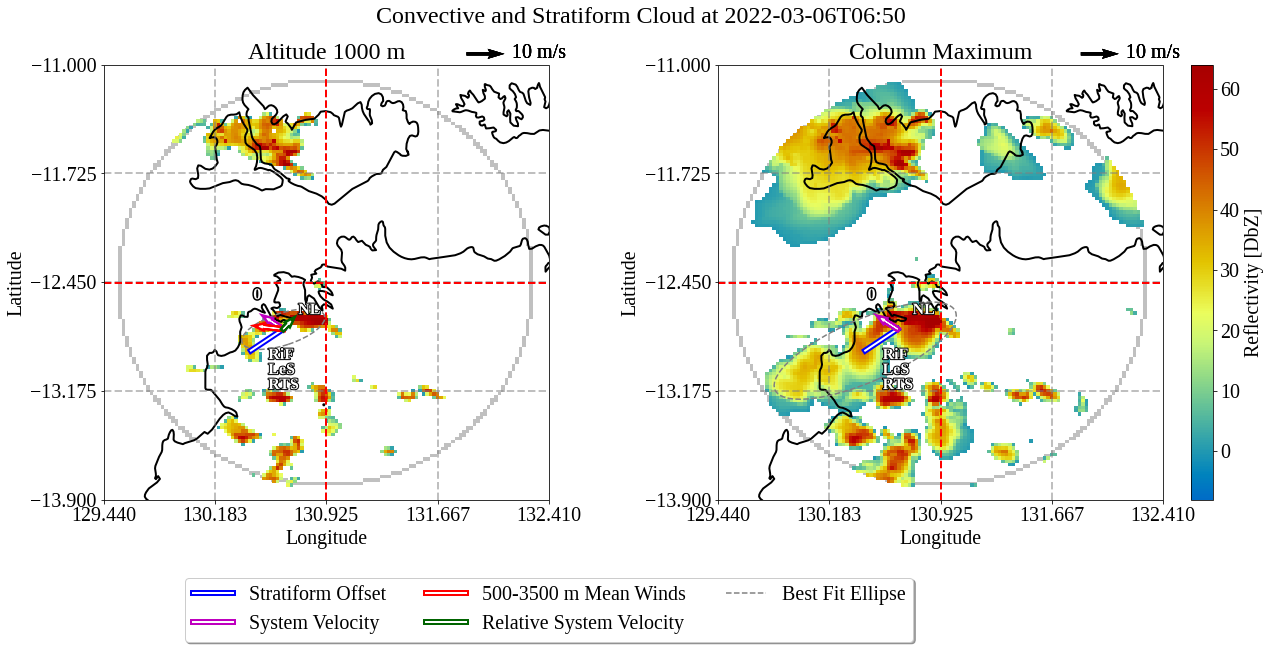

In [79]:
# filename = filenames[12]
# grid = pyart.io.read_grid(filename, include_fields=['reflectivity'])

# ACCESS_refl = tint.process_ACCESS.

current_time = str(datetime.datetime.now())[0:-7]
current_time = current_time.replace(" ", "_").replace(":", "_")
current_time = current_time.replace("-", "")

params = {
    'uid_ind': None, 'line_coords': False, 'center_cell': False,
    'cell_ind': 10, 'winds': False,
    'crosshair': True, 'fontsize': 20, 'colorbar_flag': True,
    'leg_loc': 2, 'label_type': 'velocities',
    'system_winds': ['shift', 'ambient_mean', 'relative'],
    'boundary': True, 'exclude': True}

tint.visualisation.figures.two_level(
    tracks_obj, grid, params=params, alt1=0, alt2=1)
plt.savefig(
    fig_dir + '/test_{}.png'.format(current_time), 
    dpi=200, facecolor='w', edgecolor='white', bbox_inches='tight')